In [267]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp

from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, plot_importance
import sklearn.metrics as metrics
from sklearn.utils import class_weight
from skopt import BayesSearchCV
import plotly.graph_objs as px
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors

#### PART 1: RETRIEVING AND PREPARING THE DATA

In [268]:
incident_data = pd.read_csv('./incident_event_log.csv')

In [269]:
incident_data.columns.value_counts()

number                     1
incident_state             1
impact                     1
urgency                    1
priority                   1
assignment_group           1
assigned_to                1
knowledge                  1
u_priority_confirmation    1
notify                     1
problem_id                 1
rfc                        1
vendor                     1
caused_by                  1
closed_code                1
resolved_by                1
resolved_at                1
cmdb_ci                    1
u_symptom                  1
subcategory                1
opened_by                  1
active                     1
reassignment_count         1
reopen_count               1
sys_mod_count              1
made_sla                   1
caller_id                  1
opened_at                  1
category                   1
sys_created_by             1
sys_created_at             1
sys_updated_by             1
sys_updated_at             1
contact_type               1
location      

Dataset information: 
There are 36 attributes. The attributes are divided into 3 groups which is the incident, the user and the problem. The incident group contains the attributes that describe the incident itself. the identification group contains the attributes that describe the incident and the support group contains the attributes that describe the problem. The dependent variable is the resolved_at and closed_at. The independent variables are the rest of the attributes.
1. Incident group:
    1. number: incident identifier (24,918 different values);
    2. incident state: eight levels controlling the incident management process transitions from opening until closing the case;
    3. active: boolean attribute that shows whether the record is active or closed/canceled;
    4. reassignment_count: number of times the incident has the group or the support analysts changed;
    5. reopen_count: number of times the incident resolution was rejected by the caller;
    6. sys_mod_count: number of incident updates until that moment;
    7. made_sla: boolean attribute that shows whether the incident exceeded the target SLA;
2. Identification group:
    1. caller_id: identifier of the user affected;
    2. opened_by: identifier of the user who reported the incident;
    3. opened_at: incident user opening date and time;
    4. sys_created_by: identifier of the user who registered the incident;
    5. sys_created_at: incident system creation date and time;
    6. sys_updated_by: identifier of the user who updated the incident and generated the current log record;
    7. sys_updated_at: incident system update date and time;
    8. contact_type: categorical attribute that shows by what means the incident was reported;
    9. location: identifier of the location of the place affected;
    10. category: first-level description of the affected service;
    11. subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
    12. u_symptom: description of the user perception about service availability;
    13. cmdb_ci: (confirmation item) identifier used to report the affected item (not mandatory);
    14. impact: description of the impact caused by the incident (values: 1 High; 2 Medium; 3 Low);
    15. urgency: description of the urgency informed by the user for the incident resolution (values: 1 High; 2 Medium; 3 Low);
    16. priority: calculated by the system based on 'impact' and 'urgency';
3. Support group:
    1. assignment_group: identifier of the support group in charge of the incident;
    2. assigned_to: identifier of the user in charge of the incident;
    3. knowledge: boolean attribute that shows whether a knowledge base document was used to resolve the incident;
    4. u_priority_confirmation: boolean attribute that shows whether the priority field has been double-checked;
    5. notify: categorical attribute that shows whether notifications were generated for the incident;
    6. problem_id: identifier of the problem associated with the incident;
    7. rfc: (request for change) identifier of the change request associated with the incident;
    8. vendor: identifier of the vendor in charge of the incident;
    9. caused_by: identifier of the RFC responsible by the incident;
    10. close_code: identifier of the resolution of the incident;
    11. resolved_by: identifier of the user who resolved the incident;
    12. resolved_at: incident user resolution date and time (dependent variable);
    13. closed_at: incident user close date and time (dependent variable).

As we know, the incident management is a process for recovering the normal IT service as soon as possible when anything happens to the system. At the moment, the system is full of manual work, as a result, the log is stored and can be used to build the machine learning model to improve the management process or prevent problems. In order to define the problem, I will take a first look on the dataset

In [270]:
incident_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

There are 141712 instances in the dataset with 24918 different values of incident identifier. Let check if the data contains null value

In [271]:
incident_data.isnull().sum().sum()

0

There are no missing value or null value of the dataset. Let see the correlation of the dataset to select the features that are highly correlated and choose the target.

In [272]:
# use pearson correlation
df_corr = incident_data.corr(method='pearson')
filter_corr = df_corr.unstack().sort_values(kind="quicksort", ascending=False).reset_index()
filter_corr = filter_corr[filter_corr['level_0'] != filter_corr['level_1']]
filter_corr

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/1838525157.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,level_0,level_1,0
7,active,made_sla,0.565501
8,made_sla,active,0.565501
9,reassignment_count,sys_mod_count,0.527919
10,sys_mod_count,reassignment_count,0.527919
11,sys_mod_count,reopen_count,0.247292
12,reopen_count,sys_mod_count,0.247292
13,u_priority_confirmation,sys_mod_count,0.185867
14,sys_mod_count,u_priority_confirmation,0.185867
15,reopen_count,reassignment_count,0.160193
16,reassignment_count,reopen_count,0.160193


As we can see from the correlation matrix, the active status, made_sla and reassignment_count are highly correlated with each other. Hence, there is an idea that the dataset can be used to predict the closed code, which will help the operators when new case come, they will know what to do, choose what automation process is the best for the situation. I will check closer to see if there are any idea that can be applied to the dataset. I wonder what attributes add first when the incident comes.

In [273]:
incident_data.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

There are some attributes are valid when the tickets are created. I will choose some attributes to see what insight can be get from it
1. caller_id: identifier of the user affected;
2. opened_by: identifier of the user who reported the incident;
3. sys_created_by: identifier of the user who registered the incident;
4. contact_type: categorical attribute that shows by what means the incident was reported;
5. location: identifier of the location of the place affected;
6. category: first-level description of the affected service;
7. subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
8. impact: description of the impact caused by the incident (values: 1 High; 2 Medium; 3 Low);
9. urgency: description of the urgency informed by the user for the incident resolution (values: 1 High; 2 Medium; 3 Low);
10. notify: categorical attribute that shows whether notifications were generated for the incident;

There are one attribute in this group and can be used for machine learning method, priority. If we can predict the priority of the incident, we can measure the impact of the incident and the urgency of the incident. The priority is calculated by the system based on the impact and the urgency. 

In this analysis, I will pick priority as target to build machine learning model. At first, I need to have overview of the dataset.

In [274]:
incident_data.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


We can see that there are many question marks in the dataset. I will replace the question mark with nan value.

In [275]:
incident_data.replace('?', np.nan, inplace=True)
incident_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141683 non-null  object
 8   opened_by                136877 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           88636 non-null   object
 11  sys_created_at           88636 non-null   object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

In [276]:
incident_data.isnull().sum()

number                          0
incident_state                  0
active                          0
reassignment_count              0
reopen_count                    0
sys_mod_count                   0
made_sla                        0
caller_id                      29
opened_by                    4835
opened_at                       0
sys_created_by              53076
sys_created_at              53076
sys_updated_by                  0
sys_updated_at                  0
contact_type                    0
location                       76
category                       78
subcategory                   111
u_symptom                   32964
cmdb_ci                    141267
impact                          0
urgency                         0
priority                        0
assignment_group            14213
assigned_to                 27496
knowledge                       0
u_priority_confirmation         0
notify                          0
problem_id                 139417
rfc           

## DATA PROCESSING

There are a lot of nan value in the dataset. I will drop the column with most nan value

In [277]:
# Before dropping columns, we should create a copy of the dataframe
incident_data_copy = incident_data.copy()
# drop columns with more than 50% missing values
incident_data_copy.drop(['problem_id', 'cmdb_ci', 'rfc', 'vendor', 'caused_by'], axis=1, inplace=True)
incident_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141683 non-null  object
 8   opened_by                136877 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           88636 non-null   object
 11  sys_created_at           88636 non-null   object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

As can be seen from the dataframe, there are lots of text + id in the dataset. I will drop the text and keep the id.

In [278]:
drop_pattern = r'(\d{1,4})'
# column that contains text and id
text_id_columns = ['caller_id','opened_by','sys_created_by','sys_updated_by','location','category','subcategory','u_symptom','priority','assignment_group','assigned_to', 'closed_code', 'resolved_by', 'impact', 'urgency']


# loop through the columns and drop the text
for col in text_id_columns:
    incident_data_copy[col] = incident_data_copy[col].str.extract(drop_pattern)

Now let check the dataset again compare to the original dataset

In [279]:
# compare shape of copy and original dataframe
print(incident_data_copy.shape)
print(incident_data.shape)

(141712, 31)
(141712, 36)


After preprocessing the dataset, there are 141712 instances and 29 attributes. Now let handle missing value and analysize the dataset

In [280]:
incident_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141683 non-null  object
 8   opened_by                136877 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           88636 non-null   object
 11  sys_created_at           88636 non-null   object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

Because the dataset is large, I will check the unique value of each column

In [281]:
for col in incident_data_copy.columns:
    print(col, incident_data_copy[col].nunique())

number 24918
incident_state 9
active 2
reassignment_count 28
reopen_count 9
sys_mod_count 115
made_sla 2
caller_id 5244
opened_by 207
opened_at 19849
sys_created_by 185
sys_created_at 11552
sys_updated_by 846
sys_updated_at 50664
contact_type 5
location 224
category 58
subcategory 254
u_symptom 525
impact 3
urgency 3
priority 4
assignment_group 78
assigned_to 234
knowledge 2
u_priority_confirmation 2
notify 2
closed_code 17
resolved_by 216
resolved_at 18505
closed_at 2707


At first, we can notice that there are some categorical attributes in the dataset. The correlation matrix is best when use with numerical attributes and because of the large number of numerical while there are some categorial attributes, I will convert the categorical attributes to numerical attributes. Then I will use correlation matrix to see the correlation between the attributes.

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/882533217.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 640x480 with 0 Axes>

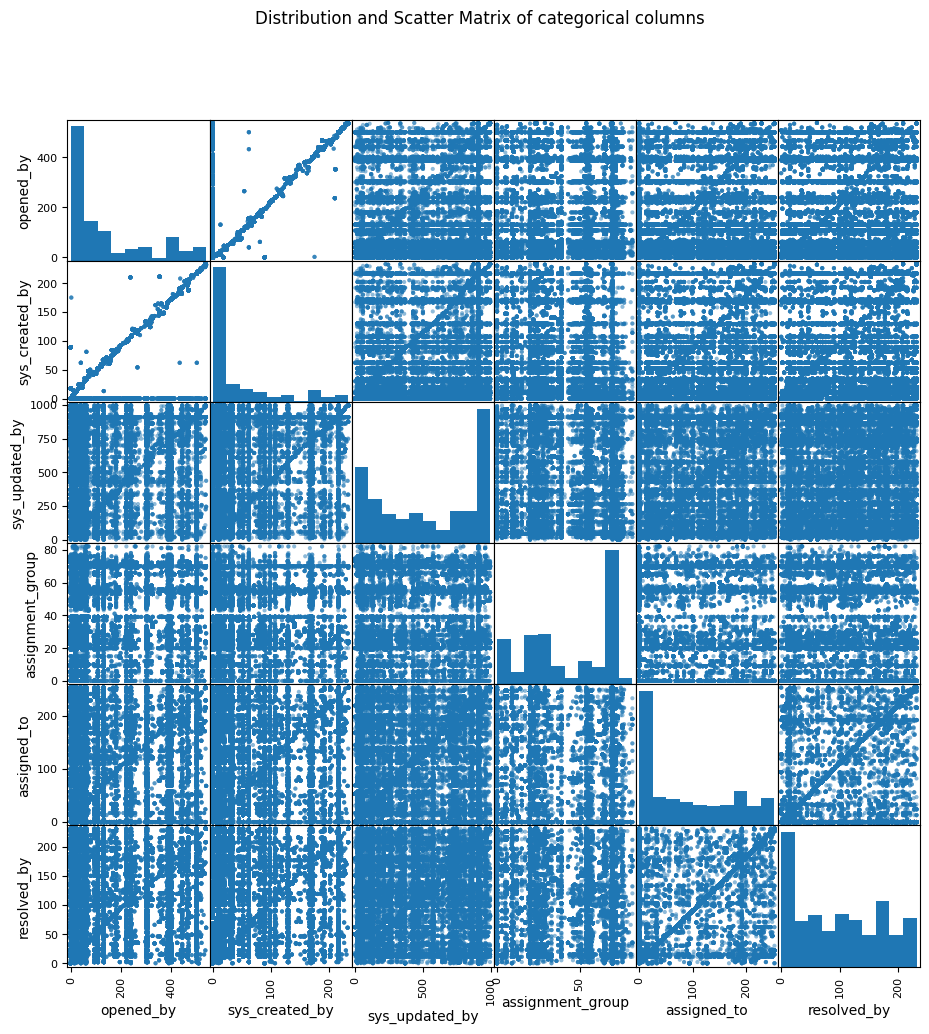

In [282]:
categorical_columns = ['opened_by','sys_created_by','sys_updated_by','assignment_group','assigned_to', 'resolved_by']
df_categorical = incident_data_copy[categorical_columns]
for col in categorical_columns:
    df_categorical[col] = pd.to_numeric(df_categorical[col], errors='coerce').fillna(0).astype(np.int64)
# Plot correlation matrix
plt.figure()
pd.plotting.scatter_matrix(df_categorical, figsize=(11,11))
# Set title
plt.suptitle('Distribution and Scatter Matrix of categorical columns')
plt.show()

From the correlation matrix, we can see that:
1. The resolved by distribution diagram is normal distributed, however, the rest of the attributes are not normal distributed, they are imbalanced
2. The relationship between sys_created_by and opened_by is fully linear, seem like who open the ticket is the same person who create the ticket
3. As same as the sys_created_by and opened_by, the assigned_to and resolved_by are nearly linear, not 100% but 70%. It means that the person who resolve the ticket is the same person who assigned to the ticket. Let see other categorical attributes

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/737032239.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 640x480 with 0 Axes>

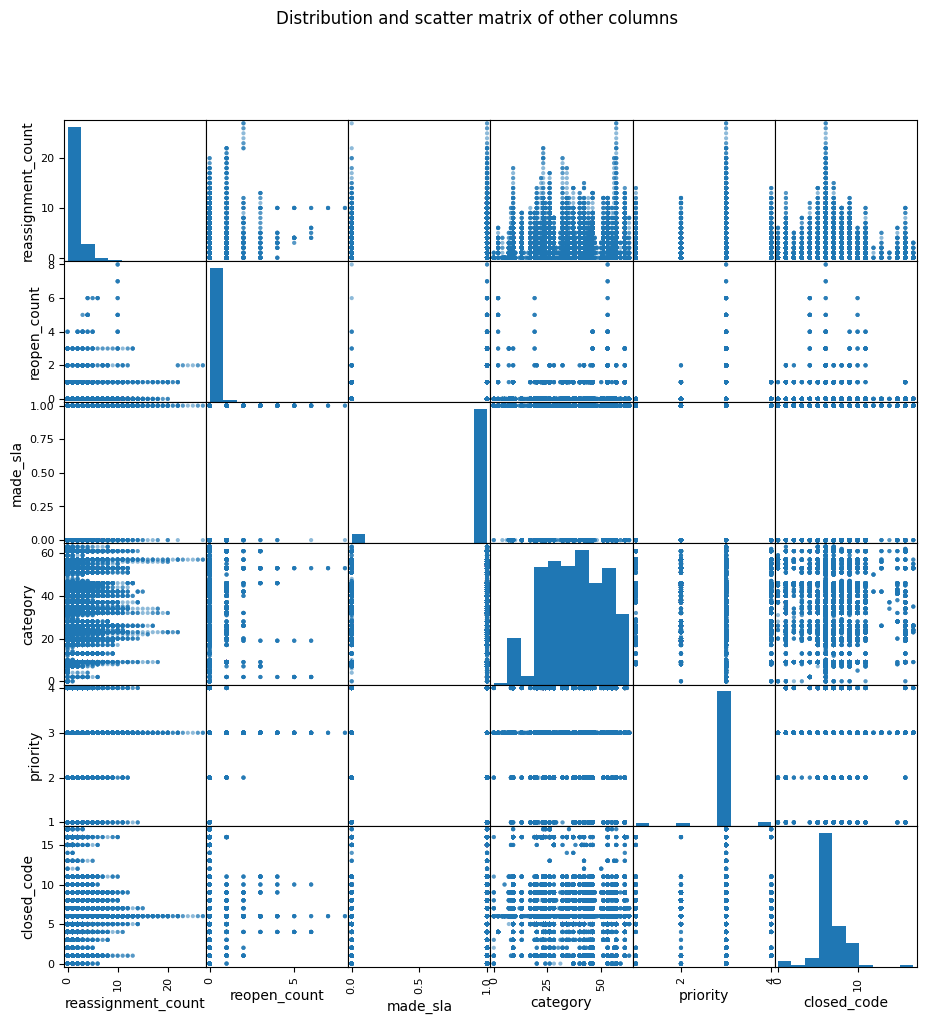

In [283]:
other_columns = ['reassignment_count','reopen_count','made_sla','category','priority','closed_code']
other_df = incident_data_copy[other_columns]
for col in other_columns:
    other_df[col] = pd.to_numeric(other_df[col], errors='coerce').fillna(0).astype(np.int64)
# Plot distribution and scatter matrix
plt.figure()
pd.plotting.scatter_matrix(other_df, figsize=(11,11))
# Set title
plt.suptitle('Distribution and scatter matrix of other columns')
plt.show()

In [284]:
incident_data['made_sla'].value_counts()

True     132497
False      9215
Name: made_sla, dtype: int64

At first, we can say that, the data is imbalanced, most of the priority is 3. The made_sla distributed mostly for value 1. The reassignment_count and reopen_count are similar with each other. Let focus on priority related column 

Based on what we found on reassignment_count and reopen_count, I will graph some plots to see it closer

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/3552643313.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




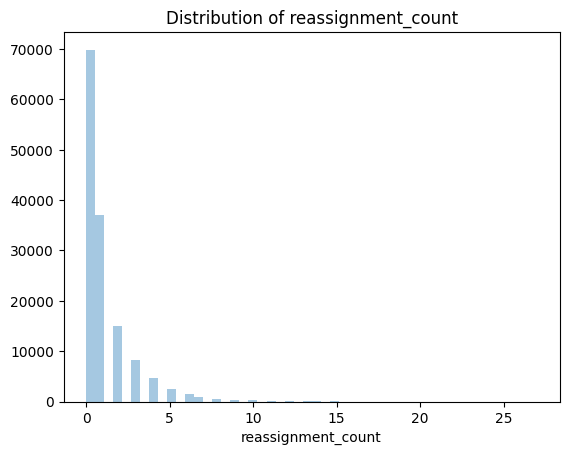

In [285]:
# Create distribution plot of reassigment_count
plt.figure()
sns.distplot(incident_data_copy['reassignment_count'], kde=False)
plt.title('Distribution of reassignment_count')
plt.show()

The data distribution in the chart above is right skewed, there are some outliers. I will remove the outliers which is occupied very small part of the dataset. Let check the describe of the reassignment_count

In [286]:
# Describe reassignment_count
incident_data_copy['reassignment_count'].describe()

count    141712.000000
mean          1.104197
std           1.734673
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          27.000000
Name: reassignment_count, dtype: float64

The outliers are very far from the mean, I will remove the outliers

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/2142168759.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




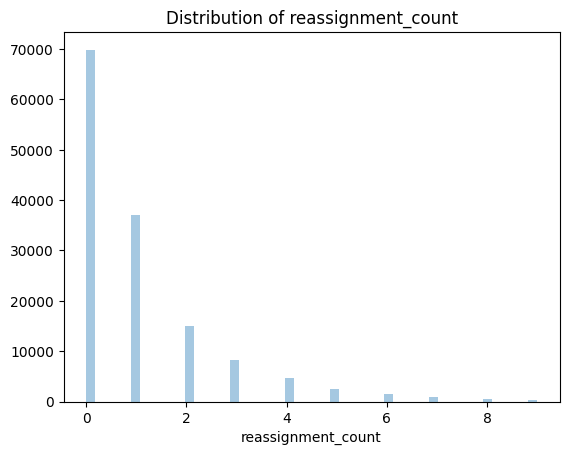

In [287]:
# Remove outliers larger than 10
incident_data_copy = incident_data_copy[incident_data_copy['reassignment_count'] < 10]
# Create distribution plot of reassigment_count
plt.figure()
sns.distplot(incident_data_copy['reassignment_count'], kde=False)
plt.title('Distribution of reassignment_count')
plt.show()

Now the outliers are removed, let check the open_count

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/3988375597.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




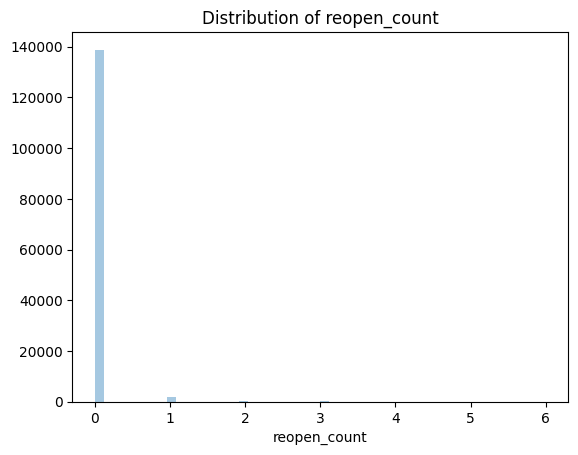

In [288]:
# Open_count distribution
plt.figure()
sns.distplot(incident_data_copy['reopen_count'], kde=False)
plt.title('Distribution of reopen_count')
plt.show()

There are some values that are very far from the main distribution, let use describe to see the outliers

In [289]:
# Describe reopen_count
incident_data_copy['reopen_count'].describe()

count    140931.000000
mean          0.019208
std           0.184225
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: reopen_count, dtype: float64

The mean is lower than 1 and the max is 6, which can detect as outliers. I will remove the outliers

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/231618339.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




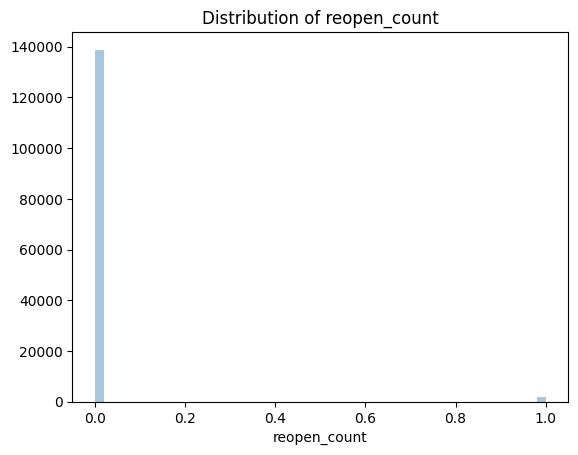

In [290]:
# Remove outliers larger than 2
incident_data_copy = incident_data_copy[incident_data_copy['reopen_count'] < 2]
# Open_count distribution
plt.figure()
sns.distplot(incident_data_copy['reopen_count'], kde=False)
plt.title('Distribution of reopen_count')
plt.show()

Now the reopen_count is cleaned, let have deep understanding of the dataset. First, the most important is incident_state. Let see the distribution of the incident_state

In [291]:
# Check if there is any missing values
incident_data_copy.isnull().sum().sum()
# Check the value counts of incident_state
print(incident_data_copy['incident_state'].value_counts())

Active                38093
New                   36375
Resolved              25589
Closed                24867
Awaiting User Info    14477
Awaiting Vendor         701
Awaiting Problem        459
Awaiting Evidence        37
-100                      5
Name: incident_state, dtype: int64


<AxesSubplot: title={'center': 'Incident State Distribution'}>

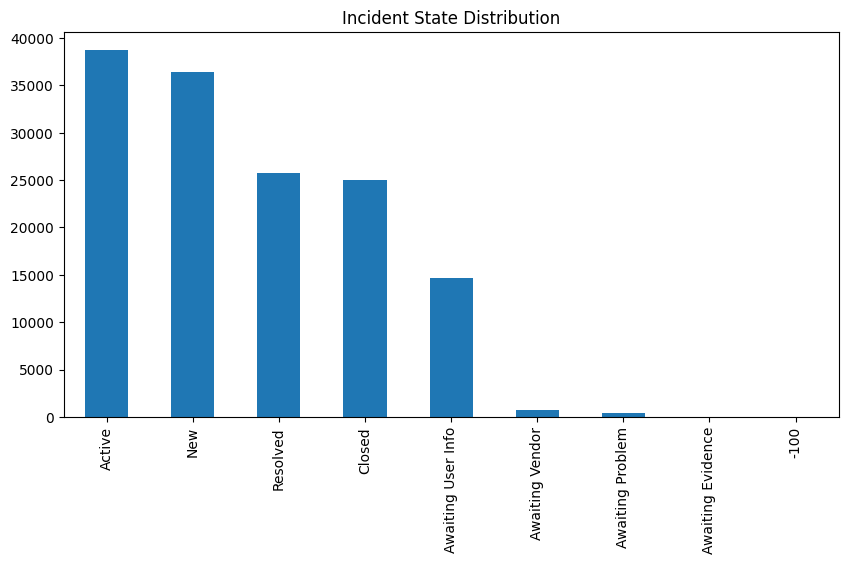

In [292]:
incident_data['incident_state'].value_counts().plot(kind='bar', title='Incident State Distribution', figsize=(10, 5))

The active and the new are the most common of incident_state. While the closed represents for the sastifiment of the customer are ranked the last. Whereas the active, new and resolved also means the case can be opened again which is represented by the reopen_count. Let see the distribution of the closed incident state

In [293]:
closed_incidents = incident_data[incident_data['incident_state'] == 'Closed']
closed_incidents.describe()

,reassignment_count,reopen_count,sys_mod_count
count,24985.000000,24985.000000,24985.000000
mean,0.941765,0.013368,6.694417
std,1.573962,0.149116,8.548757
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,2.000000
50%,0.000000,0.000000,4.000000
75%,1.000000,0.000000,8.000000
max,27.000000,8.000000,129.000000


There are 3 numerical values of the close incident, which are reassignment_count, reopen_count and sys_mod_count. Incidents are reassigned and reopened with the maximum of 27 reassignment and open mostly with 8 times. Because we are focus on the priority, I will check the priority of the closed incident

<AxesSubplot: title={'center': 'Priority Distribution of Closed Incidents'}>

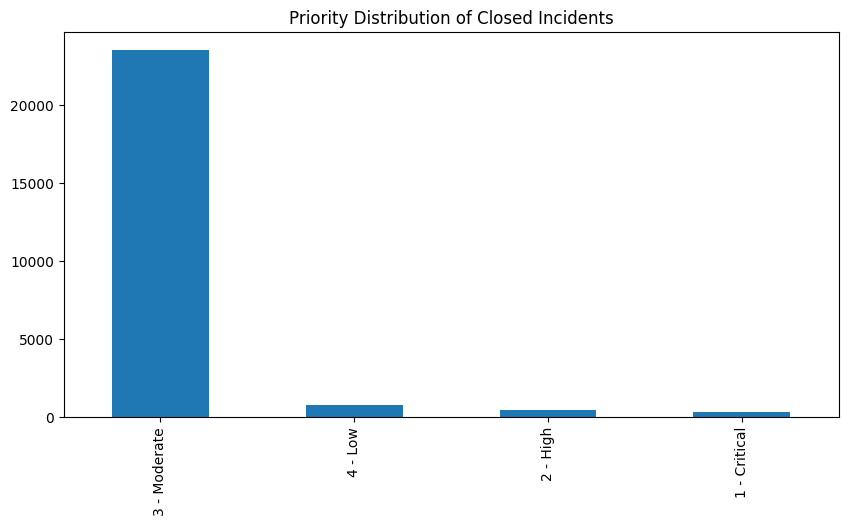

In [294]:
# Plot the priority and closed incidents state distribution
closed_incidents['priority'].value_counts().plot(kind='bar', title='Priority Distribution of Closed Incidents', figsize=(10, 5))

Interesting information, most of the closed incident are priority 3, which is the middle priority. How about the acvite and new incident

<AxesSubplot: title={'center': 'Priority Distribution of Active Incidents'}>

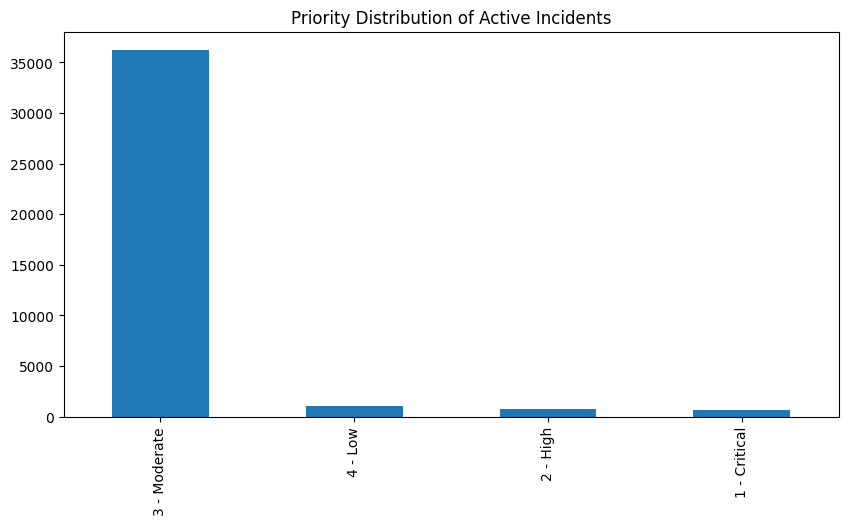

In [295]:
# Plot the priority versus active and new incidents state distribution
incident_data[incident_data['incident_state'] == 'Active']['priority'].value_counts().plot(kind='bar', title='Priority Distribution of Active Incidents', figsize=(10, 5))

<AxesSubplot: title={'center': 'Priority Distribution of New Incidents'}>

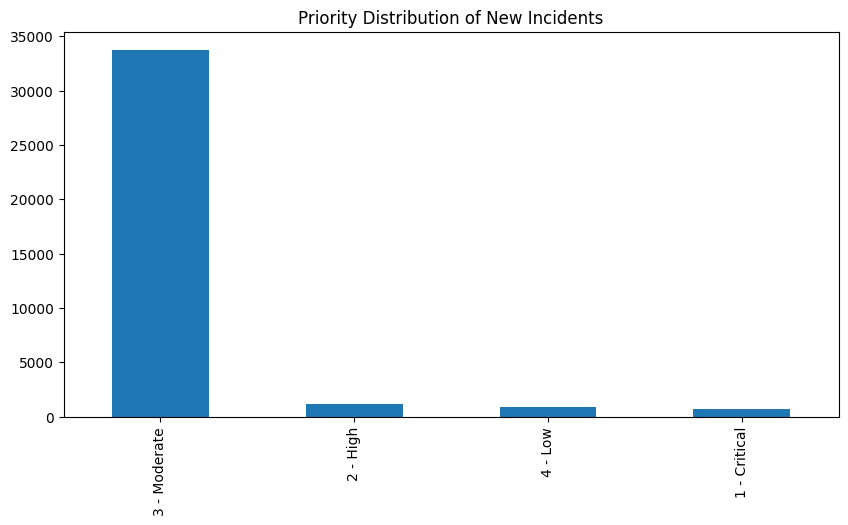

In [296]:
incident_data[incident_data['incident_state'] == 'New']['priority'].value_counts().plot(kind='bar', title='Priority Distribution of New Incidents', figsize=(10, 5))

The moderate priority is the most common priority of the active and new incident. Let see the distribution of the priority

In [297]:
# Value counts of priority
incident_data['priority'].value_counts()

3 - Moderate    132452
4 - Low           4030
2 - High          2972
1 - Critical      2258
Name: priority, dtype: int64

The data is imbalanced, most of the priority is 3. Based on what we get, let check which types of incidents being reopened most often. We have closed_code attribute, which is the reason of the incident is closed. Let see the distribution of the closed_code

code 6     86583
code 7     20733
code 9     13562
code 8      5646
code 5      4469
code 1      3265
code 10     1678
code 11     1493
code 4      1139
code 16     1091
code 3       608
code 2       349
code 15      183
code 17      115
code 13       59
code 12       13
code 14       12
Name: closed_code, dtype: int64


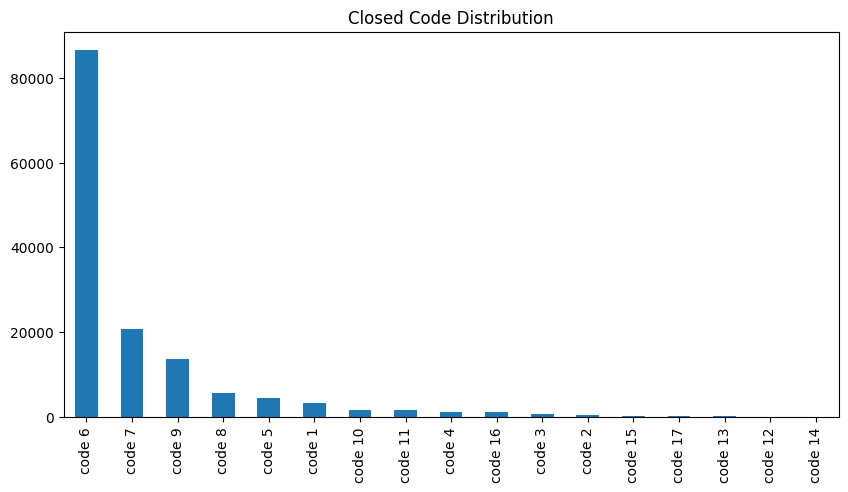

In [298]:
# Closed code distribution
incident_data['closed_code'].value_counts().plot(kind='bar', title='Closed Code Distribution', figsize=(10, 5))
print(incident_data['closed_code'].value_counts())

The closed_code 6 is the most common closed_code. Let check which closed_code is the most common for the reopen_count

<AxesSubplot: title={'center': 'Closed Code Distribution'}>

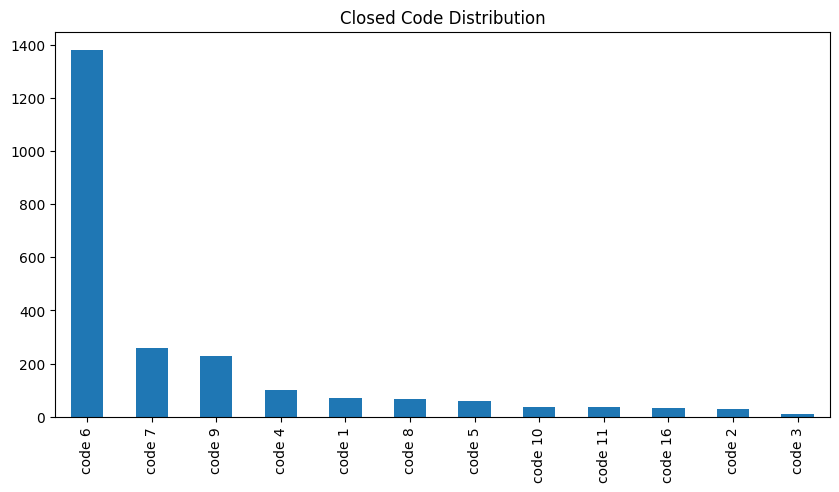

In [299]:
# Plot distribution of the closedcode with reopen_count > 0
incident_data[incident_data['reopen_count'] > 0]['closed_code'].value_counts().plot(kind='bar', title='Closed Code Distribution', figsize=(10, 5))

As same as the closed_code distribution, the closed_code 6 is the most common closed_code for the reopen_count. Let see the distribution of the closed_code and the closed state of the incident

<AxesSubplot: title={'center': 'Closed Code Distribution of Closed Incidents'}>

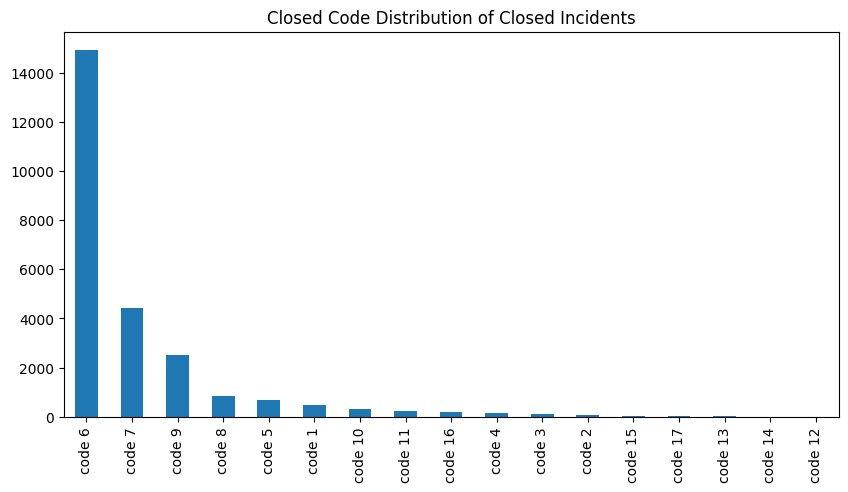

In [300]:
# Plot the distribution of the closed_code and closed incidents state
closed_incidents['closed_code'].value_counts().plot(kind='bar', title='Closed Code Distribution of Closed Incidents', figsize=(10, 5))

It is similar as other closed code distribution, now move to the made_sla attribute which is made the customer satisfied or not. Let see the distribution of the made_sla

<AxesSubplot: title={'center': 'Made SLA Distribution'}>

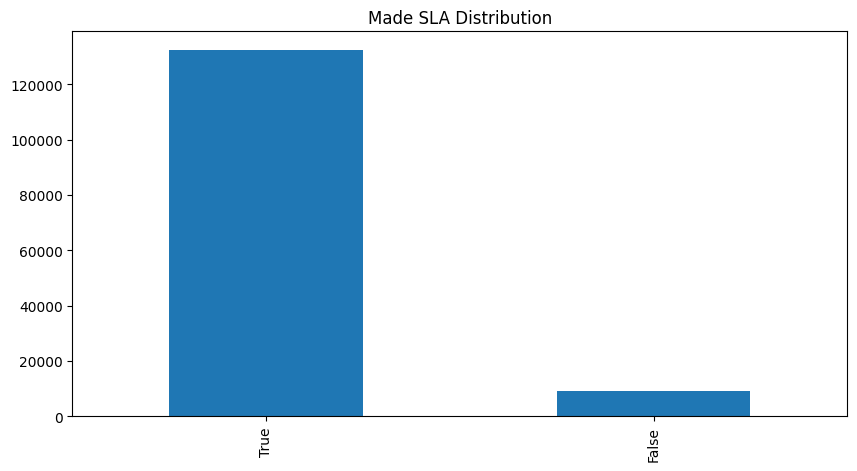

In [301]:
# Distribution of the made_sla column
incident_data['made_sla'].value_counts().plot(kind='bar', title='Made SLA Distribution', figsize=(10, 5))

The satisfied customer is the most common. Now let check how many of the reopened incident are made_sla

<AxesSubplot: title={'center': 'Made SLA Distribution'}>

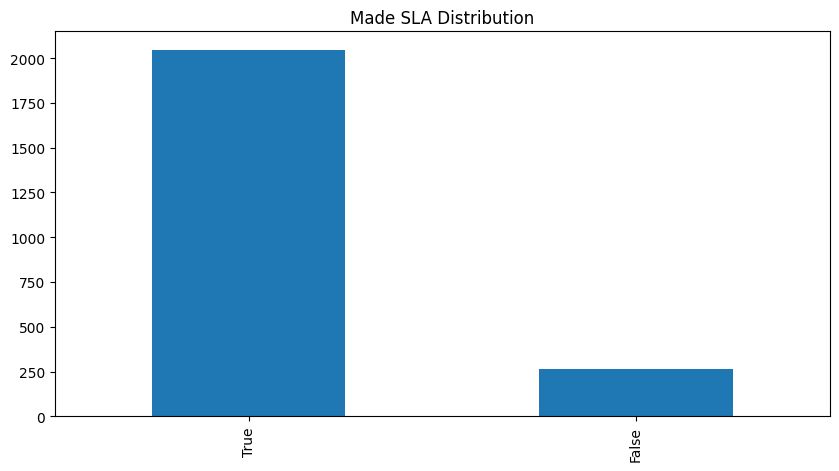

In [302]:
# Distribution of the made_sla versus the reopen_count
incident_data[incident_data['reopen_count'] > 0]['made_sla'].value_counts().plot(kind='bar', title='Made SLA Distribution', figsize=(10, 5))

We can see that only 10% of the made_sla is reopened. We can assume that if the tickets are not made_sla, the customer will reopen the ticket. Keep working on the incident, we need to figure out which priority is not satisfied the customer if the ticket is created.

In [303]:
# Make a table of the priority and made_sla
pd.crosstab(incident_data['priority'], incident_data['made_sla'])

made_sla,False,True
priority,,
1 - Critical,265,1993
2 - High,406,2566
3 - Moderate,8419,124033
4 - Low,125,3905


#### Small Conclusion

Now we notice that the higher the priority, the less satisfied the customer. So the priority is identified wrong or the ticket is not assigned to the right person. Hence it is important to predict the priority of the incident and choose the right person to assign to. This make me think to check the assigned to and the resolved by. Let see the relationship of the assigned_to and the resolved_by

<AxesSubplot: title={'center': 'Same Resolved Assigned Distribution'}>

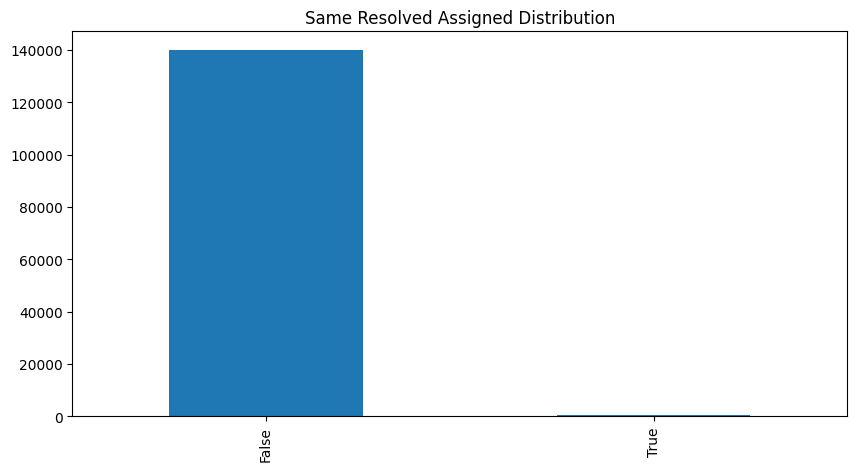

In [304]:
# Compare the assigned_to and resolved_by, let see how many is the same and plot the distribution
incident_data_copy['same_resolved_assigned'] = incident_data_copy['assigned_to'] == incident_data_copy['resolved_by']
incident_data_copy['same_resolved_assigned'].value_counts().plot(kind='bar', title='Same Resolved Assigned Distribution', figsize=(10, 5))

In [305]:
incident_data_copy['assigned_to'].value_counts()

17     10494
13      8783
194     3510
57      3131
69      2943
       ...  
146        1
67         1
38         1
131        1
129        1
Name: assigned_to, Length: 234, dtype: int64

In [306]:
incident_data_copy['resolved_by'].value_counts()

15     15248
11     11989
103     5313
177     3796
53      3608
       ...  
222        4
17         4
39         3
185        3
48         3
Name: resolved_by, Length: 216, dtype: int64

Now we can ignore the assigned_to because the one who resolve the ticket is not the same person who assigned to the ticket. Hence, only one resolved_by is important feature and we can ignore the assigned_to to predict and improve the process of the incident. Like assign the right ticket to the right person. One more thing I can think related to the closed incident and the priority is the completion time of the incident. Let check the completion time of it

In [307]:
# Closed incident data
closed_incidents = incident_data[incident_data['incident_state'] == 'Closed']
# First we need to convert the opened_at and closed_at to datetime follow format %d/%m/%d %H:%M:%S
closed_incidents['opened_at'] = pd.to_datetime(closed_incidents['opened_at'], format='%d/%m/%Y %H:%M')
closed_incidents['closed_at'] = pd.to_datetime(closed_incidents['closed_at'], format='%d/%m/%Y %H:%M')
# In order to get the completion time, we need to minus the closed_at and opened_at and convert it to days
closed_incidents['completion_time'] = (closed_incidents['closed_at'] - closed_incidents['opened_at']).dt.total_seconds() / 3600 / 24

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/2516685549.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/2516685549.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/2516685549.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/2639484640.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




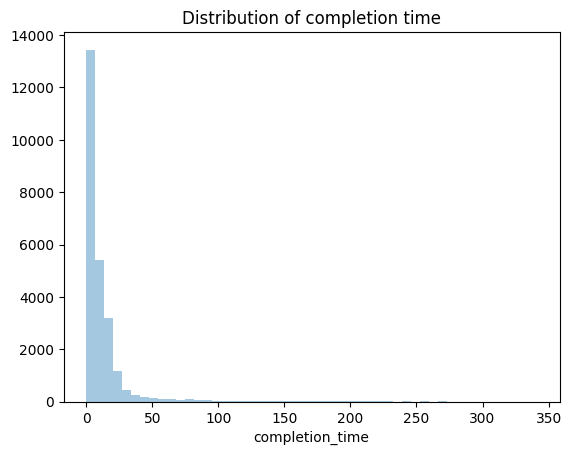

In [308]:
# Plot the distribution of the completion time
plt.figure()
sns.distplot(closed_incidents['completion_time'], kde=False)
plt.title('Distribution of completion time')
plt.show()

There are incident that need more than 100 days to complete. Let check the distribution of the completion time and the made_sla

count    15831.000000
mean         5.841620
std          4.171706
min          0.000000
25%          5.029167
50%          5.056944
75%          5.993056
max        244.025694
Name: completion_time, dtype: float64

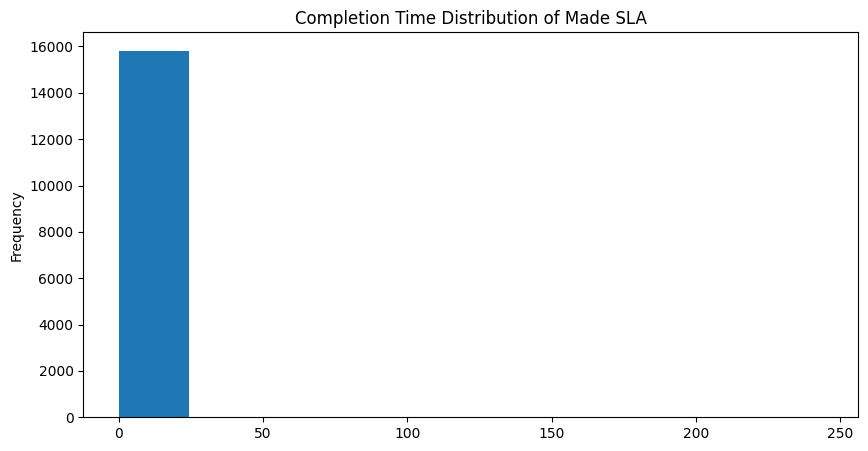

In [309]:
# Distribution of the completion time versus the made_sla
closed_incidents[closed_incidents['made_sla'] == True]['completion_time'].plot(kind='hist', title='Completion Time Distribution of Made SLA', figsize=(10, 5))
# Value counts of the completion time versus the made_sla
closed_incidents[closed_incidents['made_sla'] == True]['completion_time'].describe()

Most of the satisfied customer are completed within 10 days and the unsatisfied customer are completed more than 20 days. It make sense that the less time to complete the incident, the more satisfied the customer.

## FEATURE ENGINEERING

Because we have clearly defined the target of this analysis which is predicing priority of the incident, so only the attributes that come at the beginning of the incident report are chose. The attributes that come at the end of the incident report are not chosen because they are not available at the beginning of the incident report. The attributes that come at the beginning of the incident report are:
1. caller_id
2. opened_by
3. sys_created_by
4. contact_type
5. location
6. category
7. subcategory
8. u_symptom
9. impact
10. urgency

Let get the dataframe from those attributes

In [310]:
priority_group_train = incident_data_copy[['caller_id','opened_by','sys_created_by','contact_type','location','category','subcategory', 'u_symptom', 'made_sla']]
priority_group_test = incident_data_copy['priority']

In [311]:
# Category columns
cat_cols = ['contact_type', 'made_sla']

# Numerical columns
num_cols = ['caller_id','opened_by','sys_created_by','location','category','subcategory', 'u_symptom']

for col in num_cols:
    priority_group_train[col] = pd.to_numeric(priority_group_train[col], errors='coerce').fillna(0).astype(np.int64)

# Encoded the category columns
label_encoder = LabelEncoder()
for col in cat_cols:
    priority_group_train.loc[:,col] = label_encoder.fit_transform(priority_group_train.loc[:,col])

priority_group_test = label_encoder.fit_transform(priority_group_test)

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/2142566675.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/2142566675.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/q1/3md20s617wl5jjxdb1c9d1y00000gn/T/ipykernel_52576/2142566675.py:13: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use

Let create train and test dataset for the model with the size of 70% and 30%

In [312]:
x_train, x_test, y_train, y_test = train_test_split(priority_group_train, priority_group_test, test_size=0.3, random_state=10)

Because of the dataset is imbalance, I will use grid search to find the best parameter for the model and balance the weight of the class in the model. For this case, I will choose xgboost as the model for regression. I will use grid search to find the best parameter for the model. First let fix the training dataset into the model

## DATA MODELLING

## XGB CLASSIFIER

In [313]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

After fiting the model, let check the outcome of it

In [314]:
y_pred = xgb.predict(x_test)
# Show accuracy, precision, recall, f1-score and confusion matrix of the model
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.49      0.62       703
           1       0.85      0.59      0.70       867
           2       0.97      1.00      0.98     39398
           3       0.93      0.69      0.79      1213

    accuracy                           0.97     42181
   macro avg       0.90      0.69      0.77     42181
weighted avg       0.97      0.97      0.97     42181



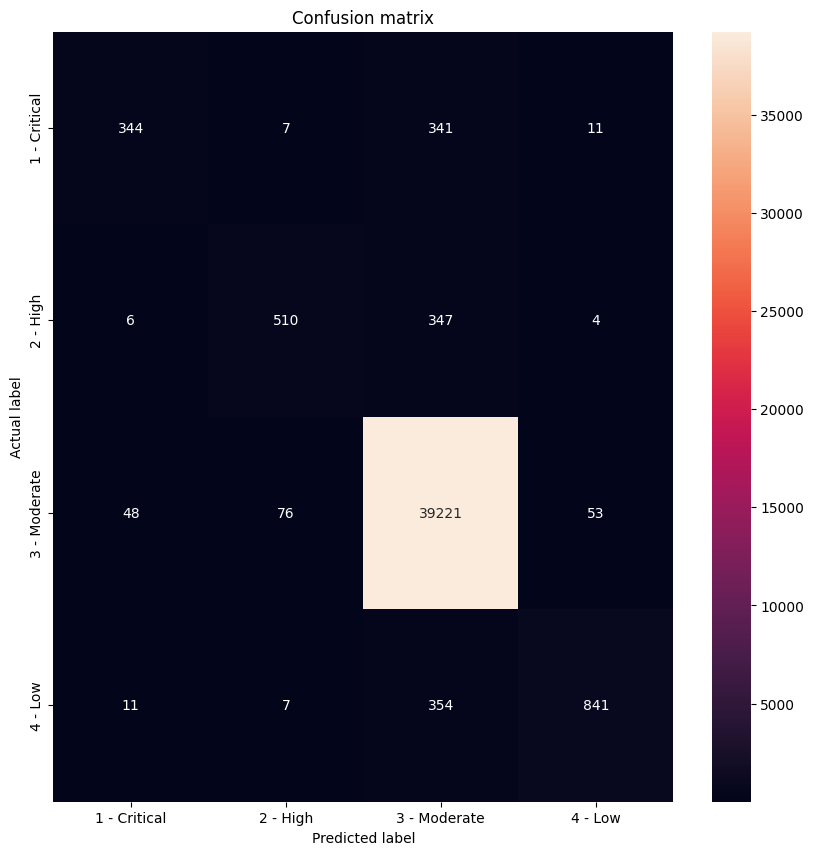

In [315]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
priority_labels = ['1 - Critical', '2 - High', '3 - Moderate', '4 - Low']
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=priority_labels, yticklabels=priority_labels, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Because of the imbalance dataset, the accuracy for predicting the priority 3 is very high. However, the accuracy for predicting the priority 1 and 2 is very low. Let use the weight balance to improve the imbalance model

Now we have result of the imbalance model, let add the parameter to balance the weight of the class

In [316]:
from sklearn.utils import class_weight
class_weight_list = list(class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train))
# Create a weight array
weight_array = np.ones(y_train.shape[0], dtype = 'float')
# Looping through the train data and assign the weight
for i, val in enumerate(y_train):
    weight_array[i] = class_weight_list[val-1]
# Create a model again with the weight
xgb_weight = XGBClassifier()
xgb_weight.fit(x_train, y_train, sample_weight=weight_array)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

Now we got the best parameter for the model, let check the result of the model again

In [317]:
y_pred_xgb_weight = xgb_weight.predict(x_test)

Let compare to the imbalance model before we add the weight

In [318]:
# Show accuracy, precision, recall, f1-score and confusion matrix of the weighted model
print(metrics.classification_report(y_test, y_pred_xgb_weight))
# Show accuracy, precision, recall, f1-score and confusion matrix of the old model
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.54      0.66       703
           1       0.83      0.78      0.81       867
           2       0.96      1.00      0.98     39398
           3       1.00      0.19      0.32      1213

    accuracy                           0.96     42181
   macro avg       0.91      0.63      0.69     42181
weighted avg       0.96      0.96      0.95     42181

              precision    recall  f1-score   support

           0       0.84      0.49      0.62       703
           1       0.85      0.59      0.70       867
           2       0.97      1.00      0.98     39398
           3       0.93      0.69      0.79      1213

    accuracy                           0.97     42181
   macro avg       0.90      0.69      0.77     42181
weighted avg       0.97      0.97      0.97     42181



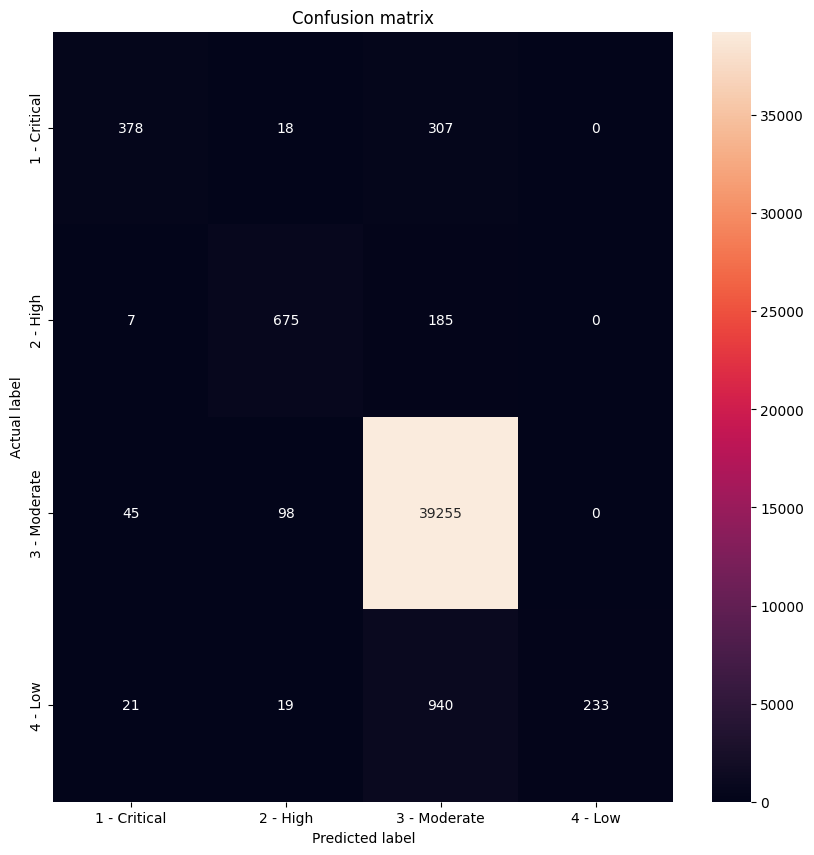

In [319]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_xgb_weight)
priority_labels = ['1 - Critical', '2 - High', '3 - Moderate', '4 - Low']
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=priority_labels, yticklabels=priority_labels, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

The result is decreased compare to the imbalance model. However, the result is still good, the recall is improved compare to the imbalance model. As we know recall score is used to measure the model performance.

Now let use gridsearch to optimize the imbalance of the model

In [320]:
search_params = {
    'learning_rate': [0.2, 0.6, 1.2],
    'max_depth': [ 3, 4, 5, 6, 8, 10],
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
grid_search = GridSearchCV(xgb_weight, search_params, scoring="f1_weighted", cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

Let see the score after using simple tuning search.

In [321]:
print(grid_search.best_params_)
y_decision_fn_gs = grid_search.predict(x_test) 
f1 = metrics.f1_score(y_test,y_decision_fn_gs,average='macro')
print(f'The F1 score for XGB_weighted model after 1st tuning:{f1}')
print(metrics.classification_report(y_test,y_decision_fn_gs))

{'learning_rate': 1.2, 'max_depth': 8}
The F1 score for XGB_weighted model after 1st tuning:0.8952280165188011
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       703
           1       0.87      0.88      0.87       867
           2       0.99      0.99      0.99     39398
           3       0.95      0.91      0.93      1213

    accuracy                           0.99     42181
   macro avg       0.90      0.89      0.90     42181
weighted avg       0.99      0.99      0.99     42181



We can see that the result is highly improve with simple tuning. Let check the confusion matrix and has a closer look to the result

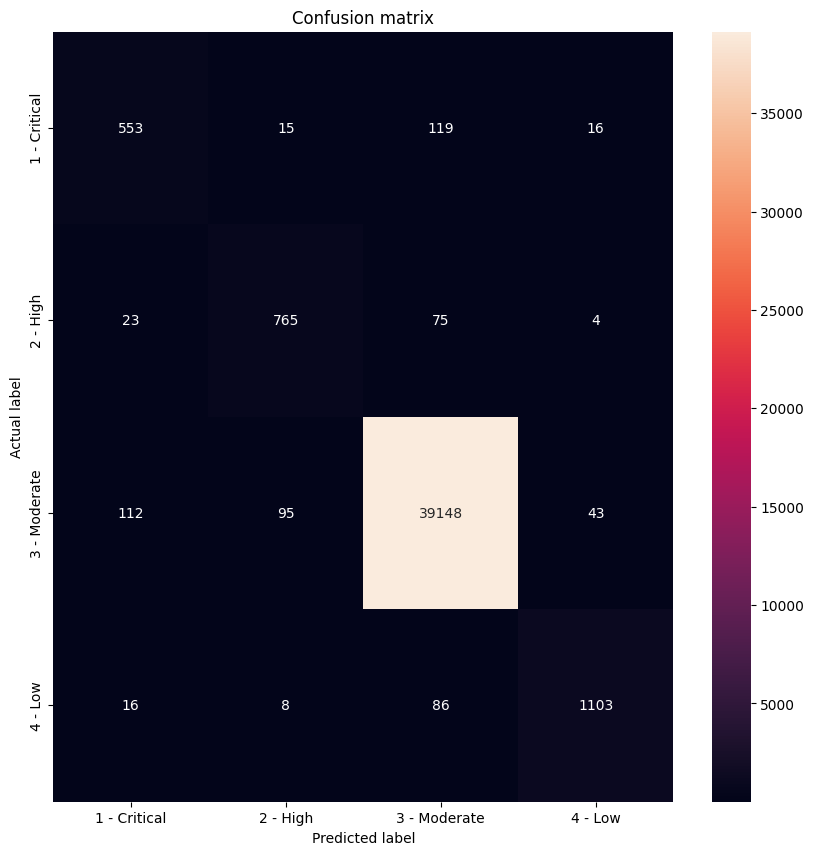

In [322]:
confusion_matrix = metrics.confusion_matrix(y_test, y_decision_fn_gs)
priority_labels = ['1 - Critical', '2 - High', '3 - Moderate', '4 - Low']
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=priority_labels, yticklabels=priority_labels, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

 Now I will use bayesian optimization to find the best parameter for the model

In [323]:
incident_data_copy['priority'].value_counts()

3    131437
4      3990
2      2940
1      2236
Name: priority, dtype: int64

In [324]:
# Replace the priority column with the encoded values
y_convert = label_encoder.fit_transform(incident_data_copy['priority'].replace({'1 - Critical': 0, '2 - High': 1, '3 - Moderate': 2, '4 - Low': 3}))
X_a, Y_a = priority_group_train.values, y_convert

In [325]:
search_params_opt = {
    'learning_rate': [0.1, 10, 'log-uniform'],
    'max_depth': (0,50),
    'n_estimators': (0, 100),
}

opt_bayes = BayesSearchCV(estimator = xgb_weight, search_spaces= search_params_opt,scoring="f1_macro", cv=kfold, n_iter=3, verbose=1)
opt_bayes.fit(X_a, Y_a)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      callbacks=None, colsample_bylevel=1,
                                      colsample_bynode=1, colsample_bytree=1,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=0, gpu_id=-1,
                                      grow_policy='depthwise',
                                      importance_type=N...
                                      max_cat_threshold=64, max_cat_to_onehot=4,
                                      max_delta_step=0, max_depth=6,
                                      max_leaves=0, min_child_weight=1,
                                      missing=nan, monotone_constraints='()',
                                      n_estimators=100, n_jobs=0,
                                      num_parallel_tree=1,
                                      objective='multi:softprob',
                                      predictor='auto', ...),
              n_iter=3, scoring='f1_macro',
              search_spaces={'learning_rate': [0.1, 10, 'log-uniform'],
                             'max_depth': (0, 50), 'n_estimators': (0, 100)},
              verbose=1)

In [326]:
# Now get the best estimator
best_xgb_weight = opt_bayes.best_estimator_
y_decision_fn = best_xgb_weight.predict(x_test)
f1 = metrics.f1_score(y_test,y_decision_fn,average='macro')
print(f'The F1 score for XGB_weighted model after 2nd tuning:{f1}')
print(metrics.classification_report(y_test,y_decision_fn))

The F1 score for XGB_weighted model after 2nd tuning:0.930411816040498
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       703
           1       0.89      0.94      0.92       867
           2       1.00      0.99      1.00     39398
           3       0.97      0.95      0.96      1213

    accuracy                           0.99     42181
   macro avg       0.92      0.94      0.93     42181
weighted avg       0.99      0.99      0.99     42181



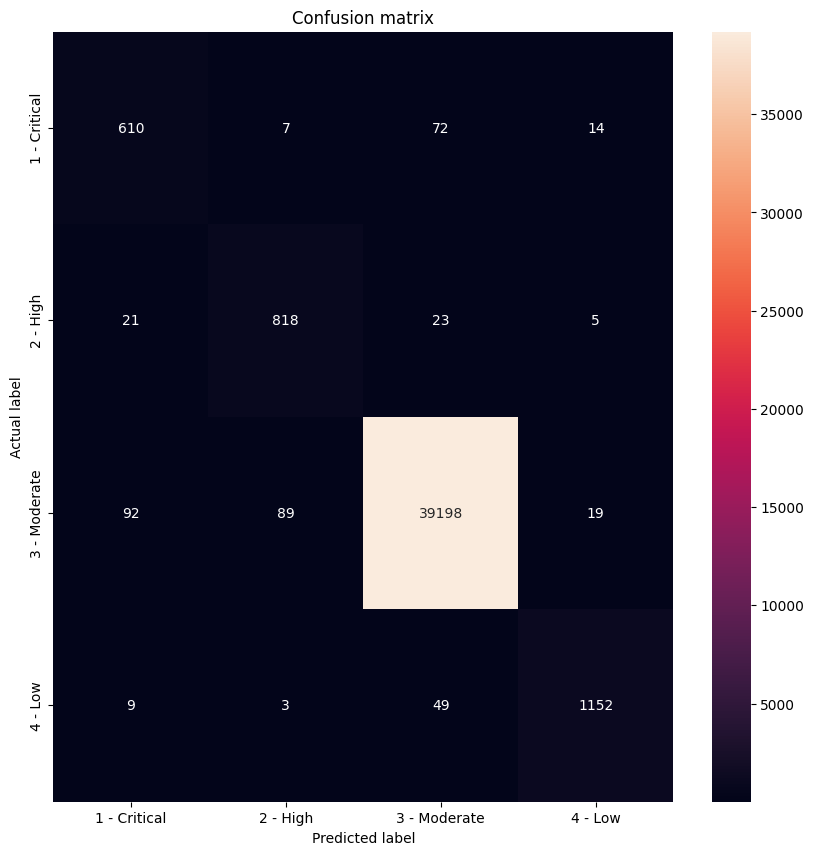

In [327]:
confusion_matrix = metrics.confusion_matrix(y_test, y_decision_fn)
priority_labels = ['1 - Critical', '2 - High', '3 - Moderate', '4 - Low']
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=priority_labels, yticklabels=priority_labels, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [328]:
print(opt_bayes.best_params_)
print(opt_bayes.best_score_)

OrderedDict([('learning_rate', 1), ('max_depth', 43), ('n_estimators', 97)])
0.8903432414890828


After finding the best parameter, let check the feature importance of the model

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

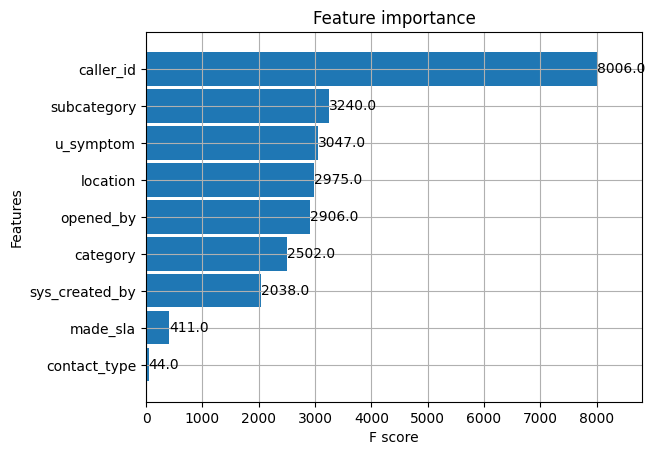

In [329]:
best_features_xgb = grid_result.best_estimator_
plot_importance(best_features_xgb, height=0.9)

#### SMALL FINDING
From the feature importance, we can see that the caller_id is the most importance feature to detect the priority, which we can assume that the user who detected the incident know how priority should the incident is, by this we can ranking the caller to prioritize their ticket since they know the priority of the incident best. The other feature is belong to the type of the incident, the IT employee who receives is the second person know which priority the incident should be placed

<AxesSubplot: title={'center': 'Top 10 Caller ID'}>

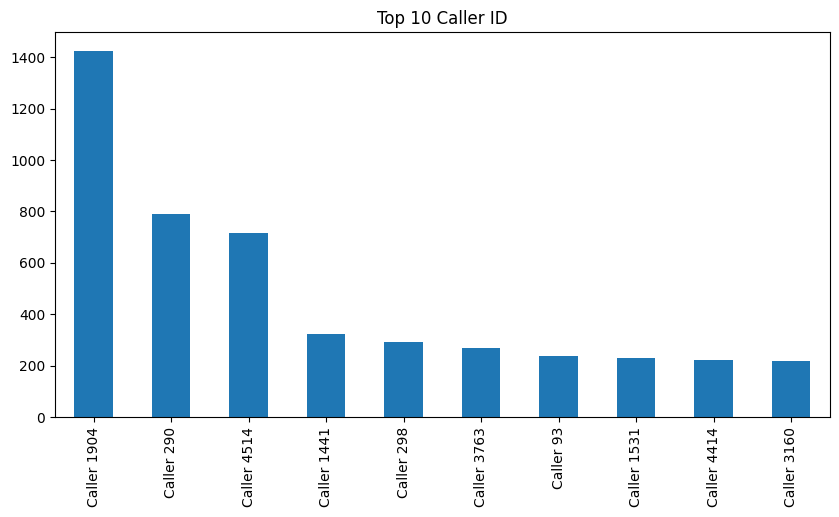

In [330]:
incident_data['caller_id'].value_counts().head(10).plot(kind='bar', title='Top 10 Caller ID', figsize=(10, 5))

Now we have the top 10 caller and seem like the caller id 1904 has detected the most incident.

Now we finished the XGBBoost model, for the next model I will choose random forest. Because the dataset is large and the target is categorical, I will use random forest to predict the priority of the incident.

### RANDOM FOREST

In [331]:
# Create a model
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train, sample_weight=weight_array)

RandomForestClassifier()

In [332]:
# Predict the model
y_pred_random_forest = random_forest.predict(x_test)
# Show accuracy, precision, recall, f1-score and confusion matrix of the model
print(metrics.classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       703
           1       0.83      0.86      0.85       867
           2       0.99      0.99      0.99     39398
           3       0.98      0.85      0.91      1213

    accuracy                           0.98     42181
   macro avg       0.89      0.85      0.87     42181
weighted avg       0.98      0.98      0.98     42181



The score of the random forest at first better than the xgbboost, now repeat the step to find the best parameter for the random forest

In [333]:
search_params_opt = {
    'max_depth': (0,50),
    'n_estimators': (0, 100),
    'min_samples_leaf': (1, 100),
    'max_features': (0, 100),
}

fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}

opt_bayes = BayesSearchCV(estimator = random_forest, search_spaces= search_params_opt,fit_params=fit_params, scoring="f1_macro", cv=kfold, n_iter=5, verbose=1)
opt_bayes.fit(X_a, Y_a)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
              estimator=RandomForestClassifier(),
              fit_params={'early_stopping_rounds': 10, 'verbose': False},
              n_iter=5, scoring='f1_macro',
              search_spaces={'max_depth': (0, 50), 'max_features': (0, 100),
                             'min_samples_leaf': (1, 100),
                             'n_estimators': (0, 100)},
              verbose=1)

In [334]:
print(opt_bayes.best_estimator_)
print(opt_bayes.best_score_)


RandomForestClassifier(max_depth=37, max_features=17, min_samples_leaf=11,
                       n_estimators=36)
0.6795713361823589


Now we have the best parameter for the model, let check the result of the model

In [335]:
# Get best estimator
best_random_forest = opt_bayes.best_estimator_
y_decision_fn_rf = best_random_forest.predict(x_test)
f1 = metrics.f1_score(y_test,y_decision_fn_rf,average='macro')
print(f'The F1 score for Random Forest model after 2nd tuning:{f1}')
print(metrics.classification_report(y_test,y_decision_fn_rf))

The F1 score for Random Forest model after 2nd tuning:0.7637008480977544
              precision    recall  f1-score   support

           0       0.84      0.43      0.57       703
           1       0.84      0.57      0.68       867
           2       0.97      1.00      0.98     39398
           3       0.93      0.73      0.82      1213

    accuracy                           0.97     42181
   macro avg       0.89      0.68      0.76     42181
weighted avg       0.97      0.97      0.97     42181



/Users/nighd/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:402: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



In [336]:
# Compare to the old model
# Show accuracy, precision, recall, f1-score and confusion matrix of the model
print(metrics.classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       703
           1       0.83      0.86      0.85       867
           2       0.99      0.99      0.99     39398
           3       0.98      0.85      0.91      1213

    accuracy                           0.98     42181
   macro avg       0.89      0.85      0.87     42181
weighted avg       0.98      0.98      0.98     42181



### COMPARISON

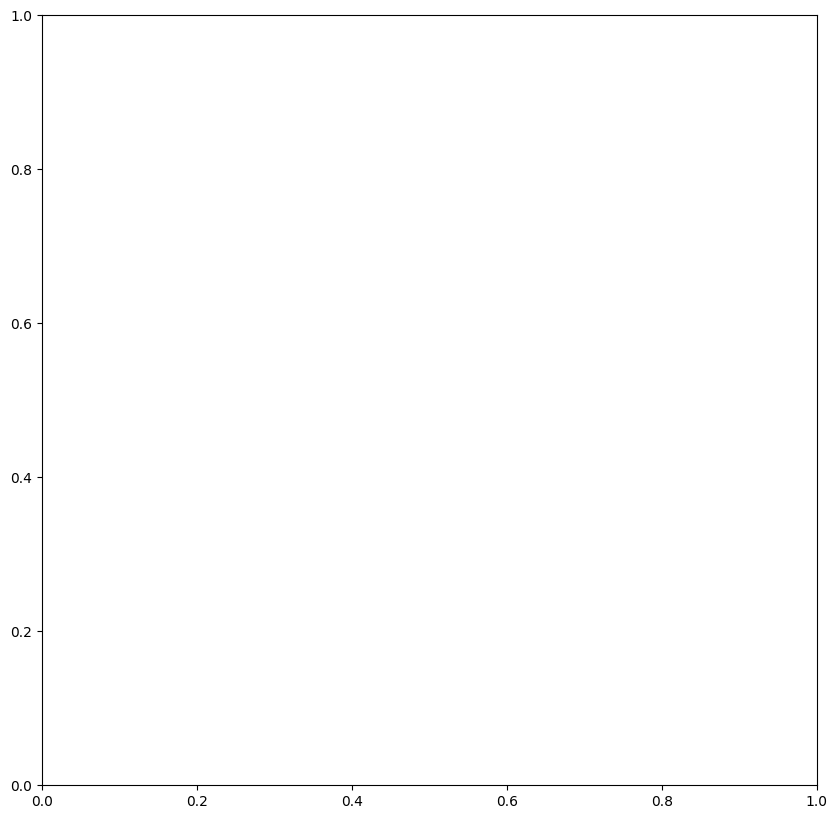

In [337]:
# Plot comparison of the two models
fig = plt.subplots(figsize=(10, 10))
trace_data = []
f1_score_xgb = metrics.f1_score(y_test, y_pred_xgb_weight, average='macro')
f1_score_random_forest = metrics.f1_score(y_test, y_pred_random_forest, average='macro')
precision_xgb = metrics.precision_score(y_test, y_pred_xgb_weight, average='macro')
precision_random_forest = metrics.precision_score(y_test, y_pred_random_forest, average='macro')
recall_xgb = metrics.recall_score(y_test, y_pred_xgb_weight, average='macro')
recall_random_forest = metrics.recall_score(y_test, y_pred_random_forest, average='macro')
accuracy_xgb = metrics.accuracy_score(y_test, y_pred_xgb_weight)
accuracy_random_forest = metrics.accuracy_score(y_test, y_pred_random_forest)
f1_score_best_xgb = metrics.f1_score(y_test, y_decision_fn, average='macro')
f1_score_best_random_forest = metrics.f1_score(y_test, y_decision_fn_rf, average='macro')
precision_best_xgb = metrics.precision_score(y_test, y_decision_fn, average='macro')
precision_best_random_forest = metrics.precision_score(y_test, y_decision_fn_rf, average='macro')
recall_best_xgb = metrics.recall_score(y_test, y_decision_fn, average='macro')
recall_best_random_forest = metrics.recall_score(y_test, y_decision_fn_rf, average='macro')
accuracy_best_xgb = metrics.accuracy_score(y_test, y_decision_fn)
accuracy_best_random_forest = metrics.accuracy_score(y_test, y_decision_fn_rf)
trace_data.append(px.Bar(x=['XGB_weighted', 'Random Forest'], y=[f1_score_xgb, f1_score_random_forest], name='F1 Score'))
trace_data.append(px.Bar(x=['XGB_weighted', 'Random Forest'], y=[precision_xgb, precision_random_forest], name='Precision'))
trace_data.append(px.Bar(x=['XGB_weighted', 'Random Forest'], y=[recall_xgb, recall_random_forest], name='Recall'))
trace_data.append(px.Bar(x=['XGB_weighted', 'Random Forest'], y=[accuracy_xgb, accuracy_random_forest], name='Accuracy'))
trace_data.append(px.Bar(x=['XGB_weighted Best', 'Random Forest Best'], y=[f1_score_best_xgb, f1_score_best_random_forest], name='F1 Score (after tuning)'))
trace_data.append(px.Bar(x=['XGB_weighted Best', 'Random Forest Best'], y=[precision_best_xgb, precision_best_random_forest], name='Precision (after tuning)'))
trace_data.append(px.Bar(x=['XGB_weighted Best', 'Random Forest Best'], y=[recall_best_xgb, recall_best_random_forest], name='Recall (after tuning)'))
trace_data.append(px.Bar(x=['XGB_weighted Best', 'Random Forest Best'], y=[accuracy_best_xgb, accuracy_best_random_forest], name='Accuracy (after tuning)'))
layout = px.Layout(title='Comparison of XGB_weighted and Random Forest', barmode='group')
fig = px.Figure(data=trace_data, layout=layout)
fig.show()

### CLUSTERING

Last models built used class weight to reduce imbalance of the dataset. However, the result is not good enough. Hence, let use resampling method to balance the dataset. The resampling method that I will use is SMOTE. SMOTE is a method to balance the dataset by oversampling the minority class. Let check the result of the model

In [338]:
# Get the numerical feature importances
importances = list(best_random_forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_train.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: caller_id            Importance: 0.33
Variable: opened_by            Importance: 0.18
Variable: location             Importance: 0.11
Variable: subcategory          Importance: 0.11
Variable: u_symptom            Importance: 0.1
Variable: sys_created_by       Importance: 0.09
Variable: category             Importance: 0.08
Variable: contact_type         Importance: 0.0
Variable: made_sla             Importance: 0.0


[None, None, None, None, None, None, None, None, None]

I will pick 5 features that have the highest importance to build the model. The features are:
1. caller_id
2. opened_by
3. subcategory
4. sys_created_by
5. category

In [339]:
# List of 5 most important features
important_features = [pair[0] for pair in feature_importances[:5]]
# Check the data types of the features
print(incident_data[important_features].dtypes)
# Print data frame of the most important features
print(incident_data[important_features].head())

caller_id      object
opened_by      object
location       object
subcategory    object
u_symptom      object
dtype: object
     caller_id       opened_by      location      subcategory    u_symptom
0  Caller 2403    Opened by  8  Location 143  Subcategory 170   Symptom 72
1  Caller 2403    Opened by  8  Location 143  Subcategory 170   Symptom 72
2  Caller 2403    Opened by  8  Location 143  Subcategory 170   Symptom 72
3  Caller 2403    Opened by  8  Location 143  Subcategory 170   Symptom 72
4  Caller 2403  Opened by  397  Location 165  Subcategory 215  Symptom 471


In [340]:
smote = SMOTE(random_state=42)
x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)

/Users/nighd/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nighd/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nighd/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nighd/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nighd/Library/Python/3.9/lib/python/site-packages/skl

Text(0, 0.5, 'Inertia')

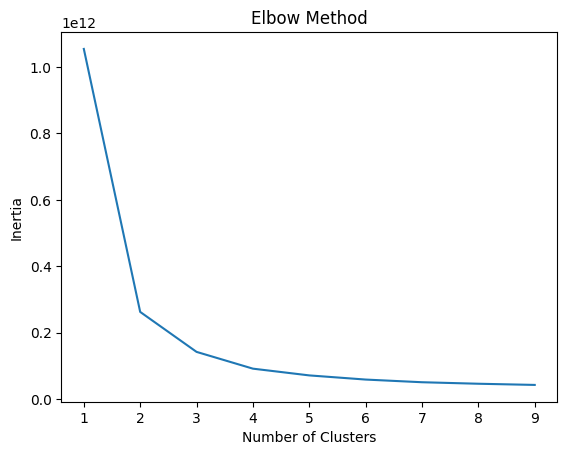

In [341]:
elbow_list = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x_train_sm)
    elbow_list.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(range(1, 10), elbow_list)
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')


### KMEAN

In [342]:
x_train_sm = pd.DataFrame(x_train_sm, columns=x_train.columns)
x_train_sm

,caller_id,opened_by,sys_created_by,contact_type,location,category,subcategory,u_symptom,made_sla
0,4757,500,217,3,108,46,94,609,1
1,4821,40,20,3,161,42,223,534,1
2,660,8,6,3,161,57,120,0,1
3,505,24,0,3,93,26,175,491,1
4,2152,386,167,3,161,53,303,494,1
...,...,...,...,...,...,...,...,...,...
368151,3646,40,20,3,143,9,164,134,1
368152,4265,221,98,3,143,53,153,387,1
368153,225,131,62,3,204,34,154,134,1
368154,154,131,62,3,108,9,164,381,1


We can see that the best number of cluster is 4. Now let check the result of the model

In [343]:
km_cluster = KMeans(n_clusters=4)
x_train_sm['cluster'] = km_cluster.fit_predict(x_train_sm)

/Users/nighd/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [344]:
# Compare x_train_sm cluster with y_train_sm
comparision_column = np.where(x_train_sm['cluster'] == y_train_sm, 1, 0)
# Convert the comparision column to a data frame
comparision_column = pd.DataFrame(comparision_column)
# Accuracy of the cluster
# Number of 0
print(comparision_column[comparision_column[0] == 0].count())
# Number of 1
print(comparision_column[comparision_column[0] == 1].count())
# Accuracy
print(comparision_column[comparision_column[0] == 1].count() / comparision_column.count())

0    255145
dtype: int64
0    113011
dtype: int64
0    0.306965
dtype: float64


The accuracy of the kmean is 0.3, which is not good enough. We can say that clustering is not suitable for the imbalanced dataset. Let try the dbscan

### DBSCAN

In [345]:
# Make a combination dataframe of x_train_sm and y_train_sm
x_train_sm['target'] = y_train_sm
st = StandardScaler()
x_train_db = st.fit_transform(x_train_sm)

In [346]:
nn = NearestNeighbors(n_neighbors=20).fit(x_train_db)
distances, indices = nn.kneighbors(x_train_db)

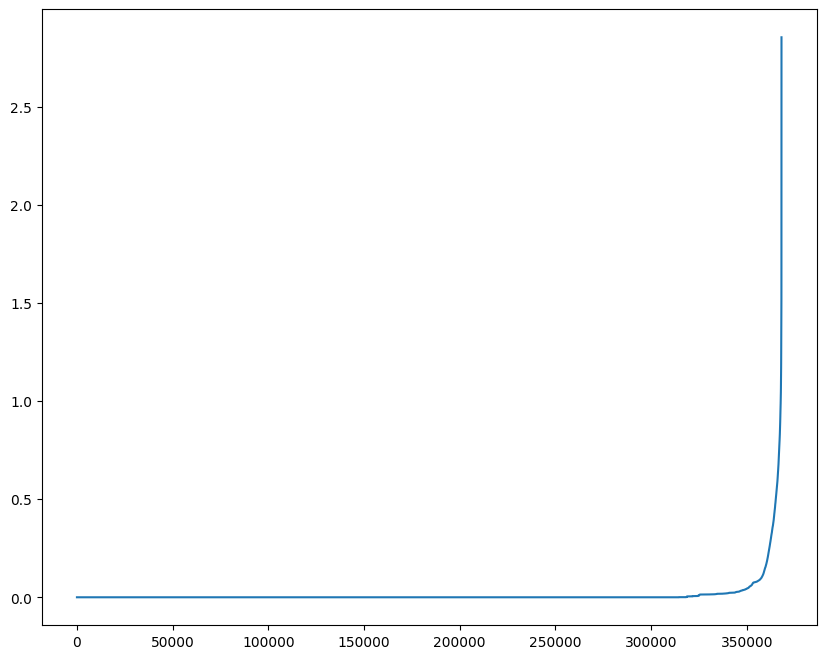

In [347]:
# Plot the distances of the nearest neighbors to find the best epsilon value
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

In [348]:

labels = DBSCAN(eps=0.4, min_samples=4).fit(x_train_db).labels_
score = metrics.silhouette_score(x_train_db, labels)
print(score)

0.21726104022689707


In [350]:
# score_kmean = metrics.silhouette_score(x_train_db, km_cluster.labels_)
# print(score_kmean)

In [351]:
y_pred_xgb_weight = xgb_weight.predict(x_test)
# Show accuracy, precision, recall, f1-score and confusion matrix of the weighted model
print(metrics.classification_report(y_test, y_pred_xgb_weight))

              precision    recall  f1-score   support

           0       0.84      0.54      0.66       703
           1       0.83      0.78      0.81       867
           2       0.96      1.00      0.98     39398
           3       1.00      0.19      0.32      1213

    accuracy                           0.96     42181
   macro avg       0.91      0.63      0.69     42181
weighted avg       0.96      0.96      0.95     42181



In [352]:
y_decision_fn = best_xgb_weight.predict(x_test)
print(metrics.classification_report(y_test,y_decision_fn))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       703
           1       0.89      0.94      0.92       867
           2       1.00      0.99      1.00     39398
           3       0.97      0.95      0.96      1213

    accuracy                           0.99     42181
   macro avg       0.92      0.94      0.93     42181
weighted avg       0.99      0.99      0.99     42181



In [353]:
# Predict the model
y_pred_random_forest = random_forest.predict(x_test)
# Show accuracy, precision, recall, f1-score and confusion matrix of the model
print(metrics.classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       703
           1       0.83      0.86      0.85       867
           2       0.99      0.99      0.99     39398
           3       0.98      0.85      0.91      1213

    accuracy                           0.98     42181
   macro avg       0.89      0.85      0.87     42181
weighted avg       0.98      0.98      0.98     42181



In [354]:
# Random forest tuning
y_decision_fn_rf = best_random_forest.predict(x_test)
print(metrics.classification_report(y_test,y_decision_fn_rf))

/Users/nighd/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:402: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



              precision    recall  f1-score   support

           0       0.84      0.43      0.57       703
           1       0.84      0.57      0.68       867
           2       0.97      1.00      0.98     39398
           3       0.93      0.73      0.82      1213

    accuracy                           0.97     42181
   macro avg       0.89      0.68      0.76     42181
weighted avg       0.97      0.97      0.97     42181

